In [54]:
#https://stackoverflow.com/questions/48828824/disable-warnings-in-jupyter-notebook
#imports
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re
import time
import random
import sys
pd.set_option('display.max_colwidth', None)

from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from scipy import sparse
from matplotlib import pyplot as plt
import utils as ut

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./data/video_games.csv')
print(ut.size_in_gb(df))

1.265136394 GB


In [4]:
df.dropna(inplace=True)

In [5]:
df.head() #preview

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,full_review
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,5,0,0,1,2015-08-31,amazing joystick I especially love twist Used Elite Dangerous mac amazing joystick I especially love twist stick different movement binding well move normal way
1,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fateful Voyage,1,0,1,1,2015-08-31,One Star poor quality work advertised
2,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation 4 and PlayStation 3,3,0,0,1,2015-08-31,good could bettee nice tend slip away stick intense hard pressed gaming session
3,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super Smash Bros Series),4,0,0,1,2015-08-31,Great flawed Great amiibo great collecting Quality material desired since perfect
4,17521011,R2F0POU5K6F73F,B008XHCLFO,24234603,Protection for your 3DS XL,5,0,0,1,2015-08-31,A Must I 2012 2013 XL durable comfortable really cool looking


I'd like to see if I can isolate the most common words in an individual item's review text. The review text was already tokenized, lemmatized, and had stop words removed during the initial read-in/cleaning process that I created so the text should be ripe for analysis.

In [6]:
len(df['product_title'].unique()) #number of unique products represented in data

15938

In [7]:
prod_list = list(df['product_title'].unique())

In [8]:
prod_list[0]

'Thrustmaster T-Flight Hotas X Flight Stick'

In [9]:
prod_list[0].split(' ')

['Thrustmaster', 'T-Flight', 'Hotas', 'X', 'Flight', 'Stick']

In [10]:
sing_prod_df = df[df['product_title']==prod_list[0]]

In [11]:
list(sing_prod_df['full_review'])[0]

'amazing joystick I especially love twist Used Elite Dangerous mac amazing joystick I especially love twist stick different movement binding well move normal way'

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
#swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one'] #custom stop word list
#cvec = CountVectorizer(stop_words=swords)

def frequency_finder(dataframe, product): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['product_title']==product] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one', 'would', 'play', 'one',
             'two', 'three', 'four', 'five', 'stars', 'get', 'this', 'they', 'good', 'great',
             'best', 'time'] #custom stop word list
    for word in product.split(' '): #split title into list on spaces
        # add words from title to stop words list - remove common punctuation characters in titles
        swords.append(word.replace('(', '').replace(')', '').replace('-','').lower())   
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords) #feed custom stop word list into cvec
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    #return text_df #return dataframe of values 
    return ', '.join(dict(text_df.sum().sort_values(ascending=False).head(5)).keys()) #return top 5 words as string

In [66]:
frequency_finder(df, prod_list[0]) #test

'joystick, throttle, button, work, control'

In [56]:
#df['top_5_rev_words'] = df['product_title'].map(lambda x: frequency_finder(df, x)) #create new column in df
#ran for WAY too long

In [62]:
#create dictionary of keywords matched w/products
vg_rev_words = {x : frequency_finder(df,x) for x in prod_list}

In [63]:
len(vg_rev_words)

15938

In [67]:
vg_rev_words[prod_list[0]] #test

'joystick, throttle, button, work, control'

In [68]:
import pickle #saving dictionary for future use
with open('./pickles/vg_text_dict.pkl', 'wb') as f:
    pickle.dump(vg_rev_words, f)

In [70]:
#confirm saving
with open('./pickles/vg_text_dict.pkl', 'rb') as f:
    testp = pickle.load(f)
print(vg_rev_words == testp) #assert the pickled dict is the same as the current one

True


Okay - that's a good snapshot of the 5 most common words for a given product. I can generalize that function and use it across all products if I decide I want to add it to my returned search values.

I'd also like to see other NLP trends like what words are common when products are grouped by average star rating - or I could group products by average star rating and compare text that way.

In [30]:
for n in range(1,6): #how many reviews are there for each star possibility?
    print()
    print(f'Star Rating: {n}')
    print(len(df[df['star_rating']==n]))


Star Rating: 1
171966

Star Rating: 2
86201

Star Rating: 3
140101

Star Rating: 4
293505

Star Rating: 5
956316


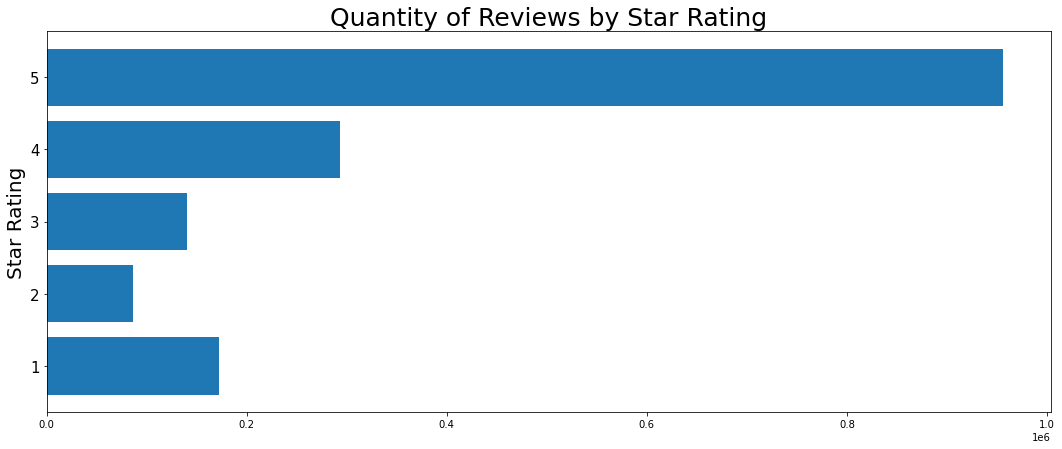

In [46]:
star_counts = dict(df.groupby('star_rating')['review_id'].count())
X = []
Y = []
for x, y in star_counts.items():
    X.append(x)
    Y.append(y)
plt.figure(figsize=(18,7))
plt.ylabel('Star Rating', size=20)
plt.yticks(size=15)
plt.title('Quantity of Reviews by Star Rating', size=25)
plt.barh(X,Y);

In [61]:
#group by review star rating (1-5)

def frequency_finder_stars(dataframe, rating): #finds most common words in revie for given product
    revs_df = dataframe[dataframe['star_rating']==rating] #make dataframe for that single product
    prod_text = list(revs_df['full_review']) #make a list of review text
    #print(prod_text[:5])
    swords = ['the', 'it', 'wa', 'br', 'use', 'game', 'like', 'one', 'would', 'play', 'one',
             'two', 'three', 'four', 'five', 'stars', 'this', 'get', 'even', 'work',
             'really', 'time', 'ha', 'much', 'good'] #custom stop word list
    #for word in product.split(' '):
        #swords.append(word.replace('(', ''). replace(')', '').lower())   # add words from title to stop words list
    #print(swords) #preview stop word list
    cvec = CountVectorizer(stop_words=swords,
                           ngram_range=(1,2), #search for words in range (#,#)
                           max_df = .4, #word can't appear more than given% of the time
                           min_df = .01,  # or less than min # times
                           max_features=5_000) #max 10_000 words
    cvec_text = cvec.fit_transform(prod_text) #pass posts through count vectorizer
    text_df = pd.DataFrame(cvec_text.todense(), columns=cvec.get_feature_names()) #make df showing word frequency

    plt.figure(figsize=(18,7))
    text_df.sum().sort_values(ascending=False).head(5).plot.barh(
    fontsize = '20',
    color='chartreuse'); #make bar chart of most frequent 10 words   
    plt.title(f'Most Frequent Words in {rating} Star Reviews', size=25)
    return plt.show() #return plot (do not save df for sake of memory) 

In [62]:
#frequency_finder_stars(df, 1)

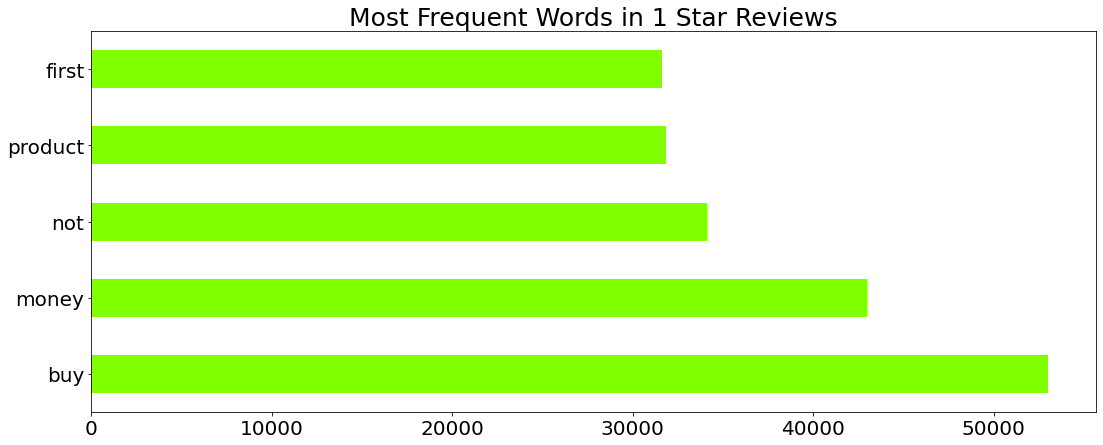

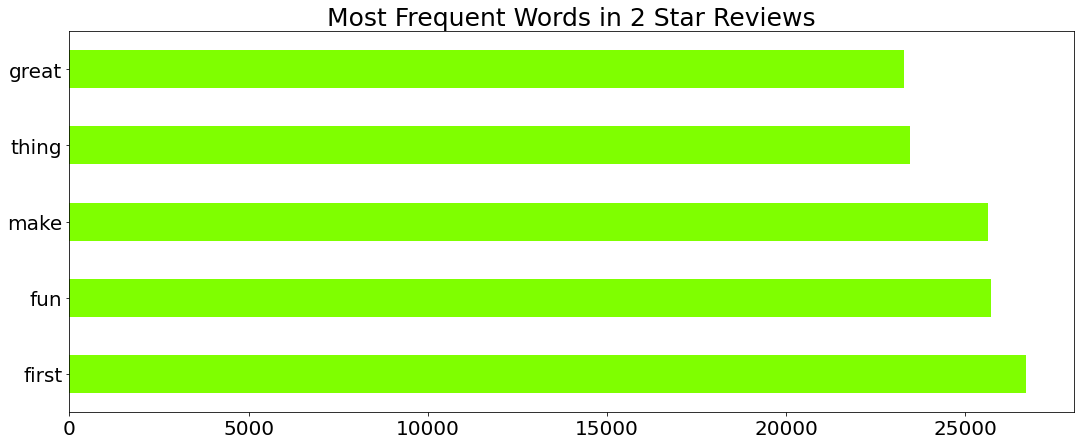

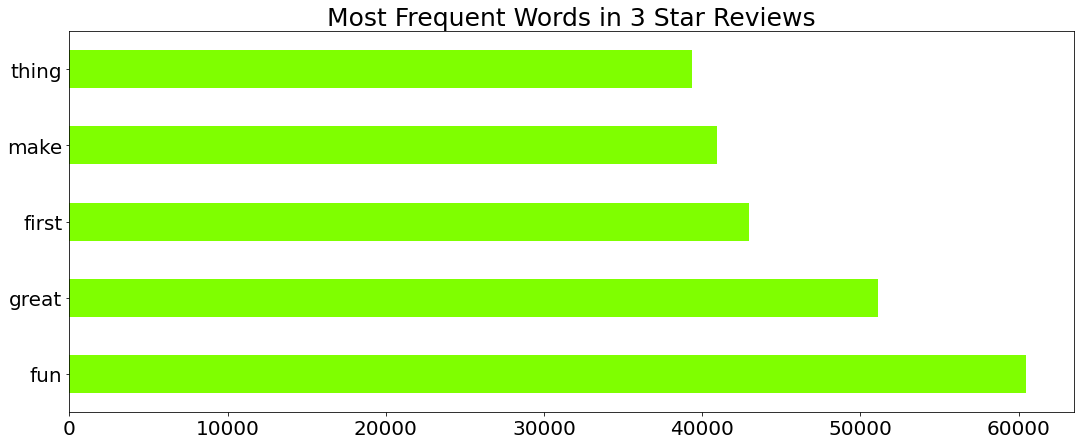

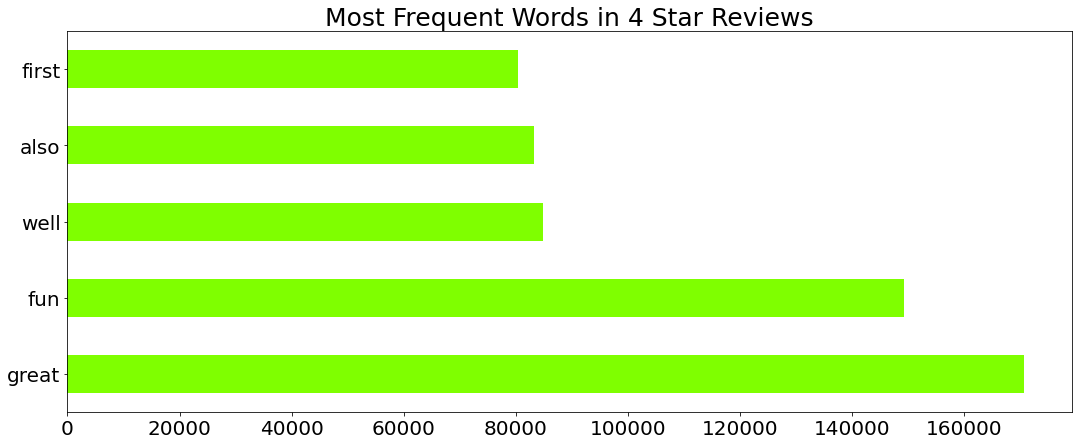

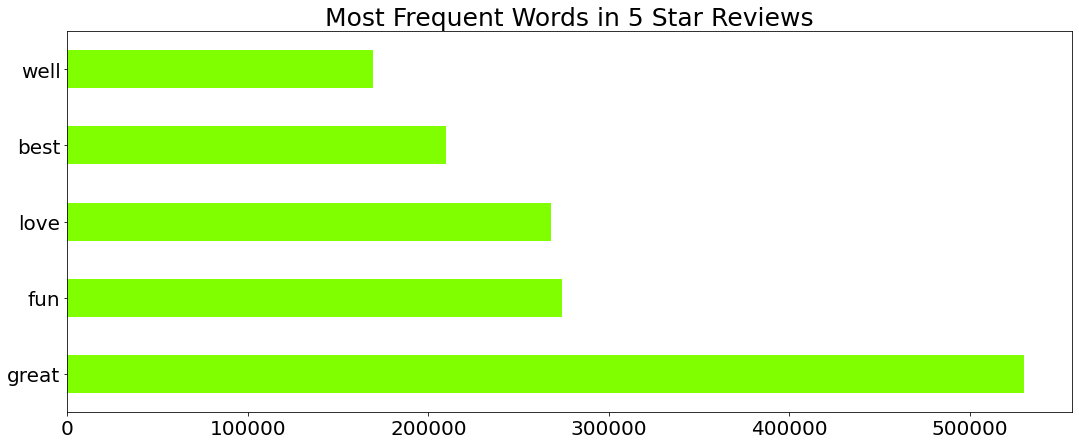

In [63]:
for n in range(1,6): #numbers 1-5
    frequency_finder_stars(df, n)